# Präsenzversuch zum Laval-Rotor

Name: Philipp Schmidt  
Datum:  1.2.2023
Gruppe:16

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:

Bei welchen Drehzahlen stellen sich bei den Prüfständen besondes hohe Schwingungen ein? Wo sollte der Betriebspunkt 
dieser liegen?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="IMG_3890.jpeg" width="500">
<img src="IMG_3891.jpeg" width="500">

Prüfstand zwei bestwht aus einem Gehäuse in dem sich eine 0,75m lange 1cm dicke Welle befindet.
Bei 25cm und 50cm sind auf der Welle zwei Scheiben mit einer Masse von 500g angebracht.
Die Welle ist an ihren Enden mit zwei Pendelrollenlagern gelagert und wird am rechten Ende von einem Steppermotor 
angetrieben.
Auf dem rechten LAger ist der Beschleungigungssensor angebracht.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_153736_lavalrotor_16_02"
)  # path to the folder with H5-file and metadata
#give h5 file a name
filename = "data_20240119_153736_lavalrotor_16_02.h5"  

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240119_153736_lavalrotor_16_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
#h5 file öffnen
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")
#neue listen für die fün einträge
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

#listen mit den Daten aus dem h5 file füllen, diese liegen unter Rawdata 
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)
#weitere leere Listen
vec_accel = list(f.keys())
y_interp = list(f.keys())
amp = list(f.keys())
freq = list(f.keys())

#listen über postprocessing.py fkt füllen
for i,j in enumerate(f.keys()):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])

for i,j in enumerate(f.keys()):
    (y_interp[i]) = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)

for i,j in enumerate(f.keys()):
    amp[i], freq[i] = m_postprocessing.my_fft_scaled(y_interp[i],interpolation_points)

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

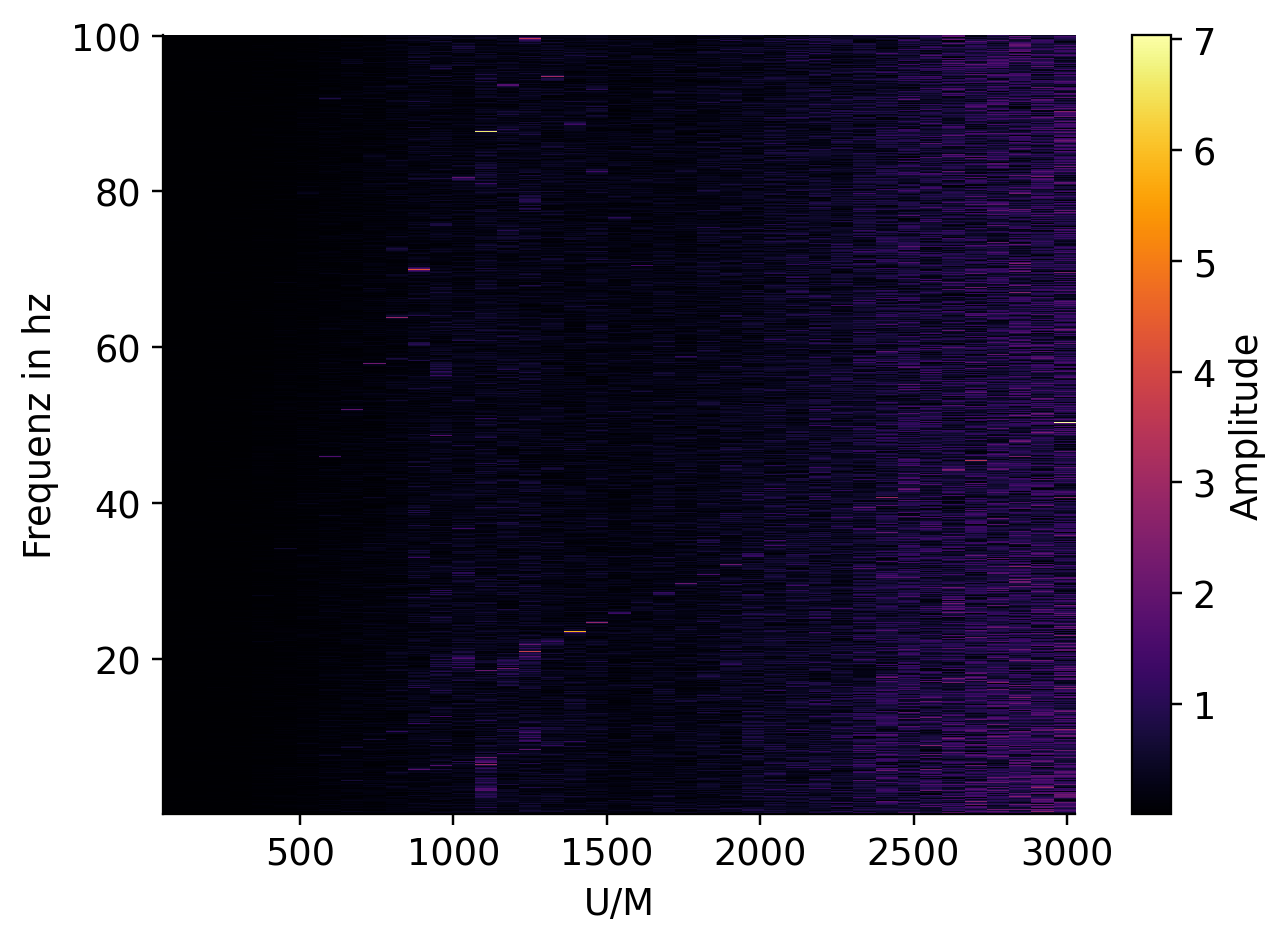

In [7]:
#matrix für die Intensität erstellen
amp_matrix = np.zeros((1000,len(f.keys())))

# matrix füllen
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]

#Graph erstellen
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0]))
           ,cmap='inferno', interpolation='None')

#Beschriftung
plt.xlabel("U/M")
plt.ylabel("Frequenz in hz")
colorbar = plt.colorbar(label="Amplitude")

## Zweiter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  
filename = "data_20240102_112539_lavalrotor_01_03.h5"
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#h5 file öffnen
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")

#neue Listen für die fünf Einträge
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

# listen mit den Daten aus dem h5 file füllen, diese liegen unter Rawdata
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)
#weitere leere Listen
vec_accel = list(f.keys())
y_interp = list(f.keys())
amp = list(f.keys())
freq = list(f.keys())

#Listen über postprocessing.py fkt füllen
for i,j in enumerate(f.keys()):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])

for i,j in enumerate(f.keys()):
    (y_interp[i]) = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)

for i,j in enumerate(f.keys()):
    amp[i], freq[i] = m_postprocessing.my_fft_scaled(y_interp[i],interpolation_points)

#### 3. Darstellung mittels Campbell-Diagramm

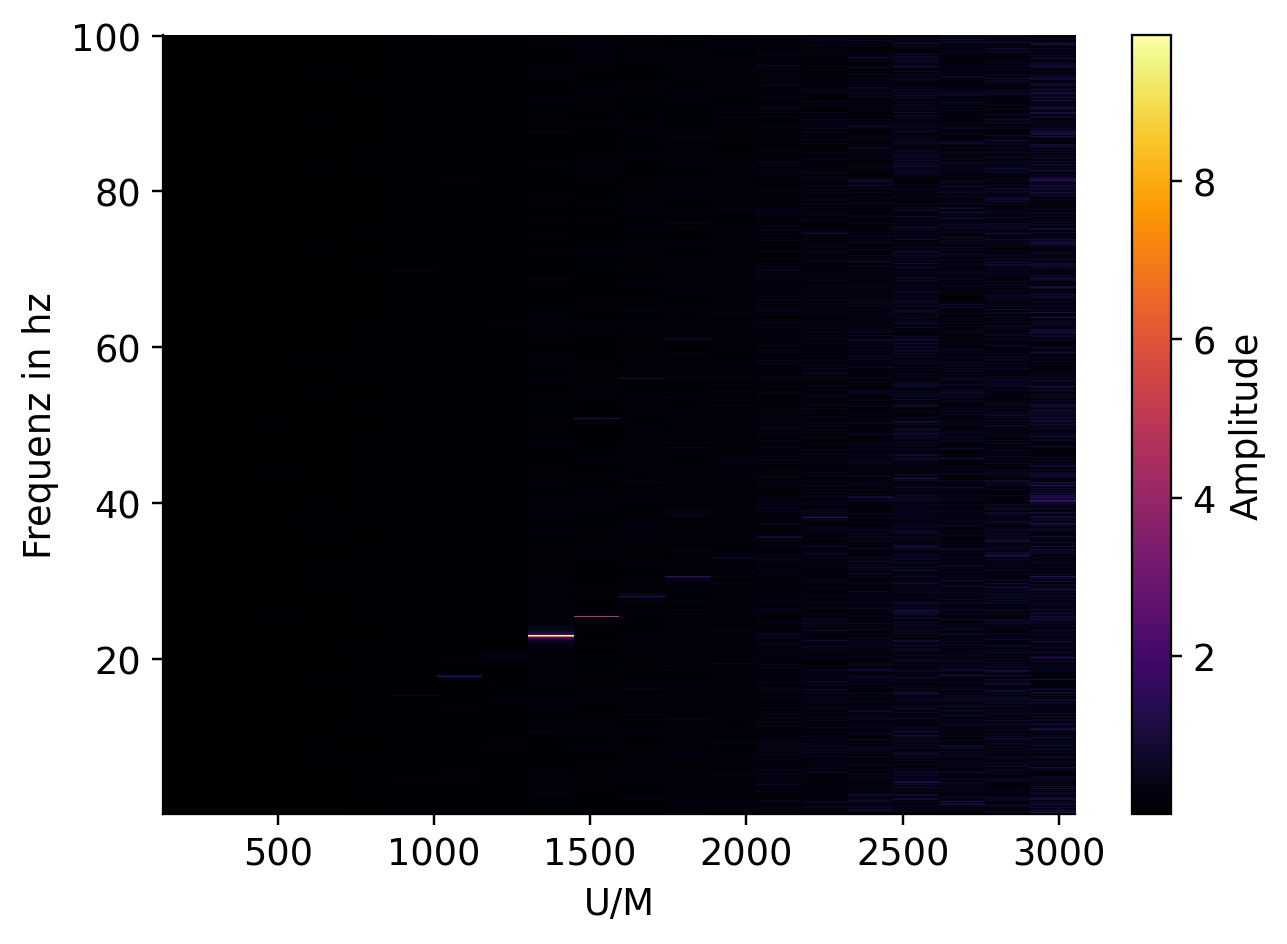

In [10]:
#Matrix für die Intensität erstellen
amp_matrix = np.zeros((1000,len(f.keys())))

#Matrix füllen 
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]

#Graph erstellen
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0]))
           ,cmap='inferno', interpolation='None')

#Beschriftung
plt.xlabel("U/M")
plt.ylabel("Frequenz in hz")
colorbar = plt.colorbar(label="Amplitude")

## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  
filename = "data_20240109_104244_lavalrotor_01_04.h5" 

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# h5 file öffnen 
path = path_measurement_folder+"/"+filename
f = h5py.File(path, "r")

#neue leere Listen für die fünf Einträge
x = list(f.keys())
y = list(f.keys())
z = list(f.keys())
timestamp = list(f.keys())
rpm = list(f.keys())

# Listen mit den Daten aus dem h5 file füllen, diese liegen unter Rawdata
for i,j in enumerate(f.keys()):
    x[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_x"])
    y[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_y"])
    z[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["acceleration_z"])
    rpm[i] = np.array(f[str(i)]["RawData"][uuid_motor_rpm]["motor_rpm"])
    timestamp[i] = np.array(f[str(i)]["RawData"][uuid_acceleration]["timestamp"])

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing) 

#weitere leere Listen
vec_accel = list(f.keys())
y_interp = list(f.keys())
amp = list(f.keys())
freq = list(f.keys())

#listen über postprocessing.py füllen
for i,j in enumerate(f.keys()):
    vec_accel[i] = m_postprocessing.get_vec_accel(x[i],y[i],z[i])

for i,j in enumerate(f.keys()):
    (y_interp[i]) = m_postprocessing.interpolation(timestamp[i],vec_accel[i], interpolation_points)

for i,j in enumerate(f.keys()):
    amp[i], freq[i] = m_postprocessing.my_fft_scaled(y_interp[i],interpolation_points)

#### 3. Darstellung mittels Campbell-Diagramm

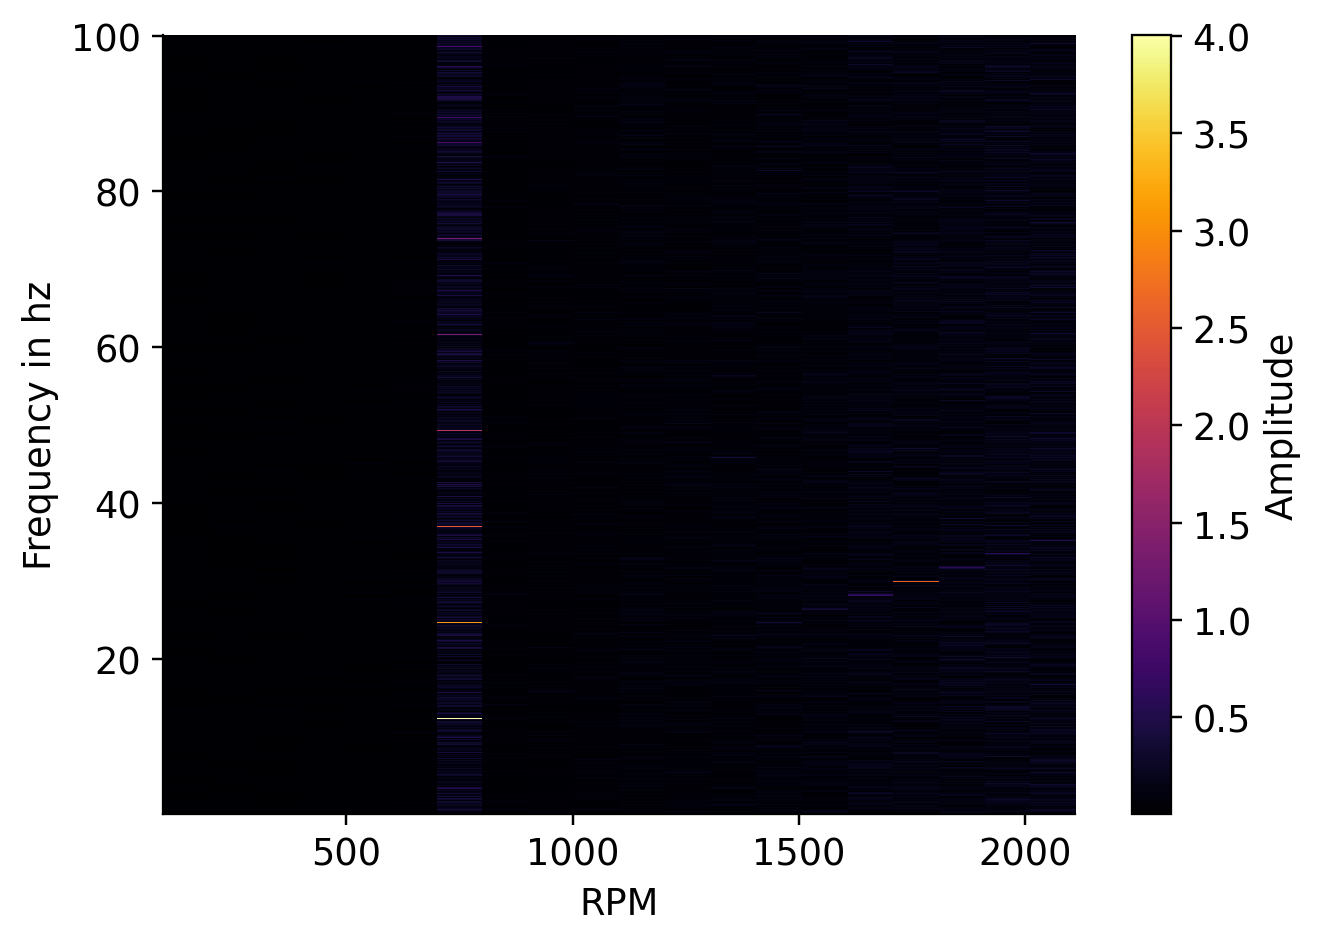

In [13]:
#Matrix für die Intensität erstellen
amp_matrix = np.zeros((1000,len(f.keys())))

#matrix füllen 
for i,j in enumerate(f.keys()):
    amp_matrix[:,i] = amp[i]

#Graph erstellen
plt.imshow(amp_matrix, aspect='auto', origin='lower', extent=(rpm[0], rpm[-1], min(freq[0]), max(freq[0]))
           ,cmap='inferno', interpolation='None')

#Beschriftung
plt.xlabel("RPM")
plt.ylabel("Frequency in hz")
colorbar = plt.colorbar(label="Amplitude")

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Auswertung erster Versuch:
<img src="G1.jpg" width="500">
In dem Campbell Diagramm lassen sich zwei Bereiche erkennen in denen das System stark schwingt, diese sind 
zwischen der linken und mittleren roten Linie sowie rechts der rechten roten Linie. Des weiteren lassen sich zwei blau eingezeichnete Geraden erkennen bei denen starke Schwingungen auftreten. Der Betriebspunkt sollte außerhalb dieeser roten Bereiche gewählt werden um einen sicheren Betrieb zu gewährleisten.

Auswwertung zweiter Versuch:
<img src="G2.jpg" width="500">
Im Campbell Diagramm lässt sich zwei Blau eingezeichente Geraden starker Schwingungen erkennen. Sowie zwei besonders starke Bereiche bei etwa 1500U/M, gelb eingewellenausführkreist. Vermutlich kommt bei diesem Prüfstand einen mit ebenfalls zwei Scheiben aber einer deutlich steiferen Wellenausführung wodurch die Schwingungnen viel kleiner ausfallen als beim errsten Versuch. Der Betriebspunkt kann auf dem Gesamten Drehzahlspektrum gewählt werden.

Auswertung dritter Versuch:
<img src="G3.jpg" width="500">
Im Campbell Diagramm lässt sich eine blau eingezeichnete Gerade starker Schwingungen erkennen. Auf der bei etwa 2500U/M ein besonders starke 30Hz Schwingung auftritt. Des weiteren fällt der Rot eingezeichnete Bereich zweischen 700 und 800 U/M auf in dem  Schwingungen aller Frequenzen stark auftreten. Die untersiedlichen Intensitäten in dieesem Bereich errinnern stark an eine stehende Welle. Der Betriebspunkt sollte links dieses Bereiches liegen um diesen nicht beim Anlaufen durchfahren zu müsen. Weiterhin vermute ich hier eine Welle mit. nur einer Scheibe.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Der Vergleich zur errechneten Kritische nDrehzahl ist mir nur im ersten Versuch möglich da die Rechnung nur für den ersten Verrsuch angestellt wurdde. Die erste errechente kritische Drehzahl liegt mit etwa 770 U/M gerade so im ersten bereich starker Schwingungen, während die zweite mit etewa 2900U/M deutlich im bereich starker Schwingungen liegt. Problematisch hierbei ist dass die Rechnuhn nur vor zwei Drehzahlen warnt während im Realsystem ein grutes Drittel aller Drehzahlen zu starken SChwingungne führt.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Mir hat der Versuch vor Ort SPas gemacht und in der Ausweertung war ich erschreckt davon wie unzureichend eigentlich eine reine Berechnung kritischer Drehzahlen eines so simplen Systems ausfällt.